# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Getting Started

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration 

In [2]:
# view data as it was read in
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.shape

(10, 6)

In addition to the user id, the portfolio data has 3 numeric variables as well as two nominal categorical variables that will need to be one-hot-encoded to get dummies.

In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
profile.shape

(17000, 5)

The profile data also includes the user id. There are missing values for both gender and income. Gender will need to be one-hot-encoded as well. Additionally, "became_member_on" will need to be reformatted using datetime.

In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
transcript.shape

(306534, 4)

The transcript data calls the user id "person" instead, which will be important to remember when combining the datasets. Event will need to be one-hot-encoded. Value and time need to be further explored.  

## Portfolio Cleanup

**portfolio.json** -  containing offer ids and meta data about each offer (duration, type, etc.)

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

Since there are multiple possible 'channels' a promotion might be sent through in the portfolio df, it is necessary to use MultiLabelBinizer rather than OneHotEncoder to encode this feature. 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

In [8]:
def clean_portfolio(portfolio):
    '''
    cleaning the portfolio dataframe

    INPUT:
    portfolio - the original dataframe to be cleaned

    OUTPUT:
    cleaned_portfolio - the cleaned dataframe
    '''
    cleaned_portfolio = portfolio.copy()
    
    # create binary channels
    mlb = MultiLabelBinarizer()
    binary_channels = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)
   
    # create binary offer types
    binary_offer_types = portfolio['offer_type'].str.get_dummies()

    # concat
    cleaned_portfolio = pd.concat([cleaned_portfolio, binary_channels], axis=1)
    cleaned_portfolio = pd.concat([cleaned_portfolio, binary_offer_types], axis=1)
    
    # drop
    cleaned_portfolio.drop(['channels'], axis=1, inplace=True)

    # change duration to hours to match transactions df
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # rename id column
    cleaned_portfolio.rename(columns={"id": "offer_id"}, inplace=True)

    # rename offer_ids for easier visualiztion, reflecting offer type
    cleaned_portfolio.replace({'offer_id' : {'^a.+0ddfd$' : 'B1', '^4.+e8da0$' : 'B2', '^3.+a8bed$' : 'I1', '^9.+9e6d9$' : 'B3',
                                             '^0.+2e1d7$' : 'D1', '^2.+fb8c2$' : 'D2','^f.+fc2a4$' : 'D3', '^5.+b9837$' : 'I2', 
                                             '^f.+0e20d$' : 'B4', '^2.+daaa5$' : 'D4'}}, regex=True, inplace=True)

    return cleaned_portfolio

In [9]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,B1,1,1,1,0,1,0,0
1,10,10,120,bogo,B2,1,1,1,1,1,0,0
2,0,0,96,informational,I1,1,1,0,1,0,0,1
3,5,5,168,bogo,B3,1,1,0,1,1,0,0
4,5,20,240,discount,D1,1,0,0,1,0,1,0
5,3,7,168,discount,D2,1,1,1,1,0,1,0
6,2,10,240,discount,D3,1,1,1,1,0,1,0
7,0,0,72,informational,I2,1,1,1,0,0,0,1
8,5,5,120,bogo,B4,1,1,1,1,1,0,0
9,2,10,168,discount,D4,1,1,0,1,0,1,0


## Profile Cleanup

**profile.json** - demographic data for each customer
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

I see that 'gender' and 'income' have the same number of missing values. From the description of data, I know that missing values for 'age' are encoded as 118. So I checked and found the same number of missing values for 'age'. With so much missing data for these observations, I will just drop these. 

Having the membership date in the correct format will make it easier to work with, but still doesn't help me much in terms of visualizing this feature. I'd like to know how long the user has been a member, which can be formated as a simple integer. (https://stackoverflow.com/questions/53867536/pandas-subtracting-current-date-from-the-date-in-a-pandas-table) 

In [11]:
def clean_profile(profile):
    '''
    cleaning the profile dataframe

    INPUT:
    profile - the original dataframe to be cleaned

    OUTPUT:
    cleaned_profile - the cleaned dataframe
    '''
    cleaned_profile = profile.copy()

    # drop null (null age is encoded as 118)
    cleaned_profile.drop(cleaned_profile[cleaned_profile.age > 100].index, inplace = True)

    # create binary columns for each gender
    binary_genders = cleaned_profile['gender'].str.get_dummies()
    cleaned_profile = pd.concat([cleaned_profile, binary_genders], axis=1)
    
    # standardize date variable and convert to the number of days a customer has been a member, "member_days"
    cleaned_profile['became_member_on'] = pd.to_datetime(cleaned_profile['became_member_on'], format='%Y%m%d')
    cleaned_profile['member_days'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_profile['became_member_on']).dt.date
    cleaned_profile['member_days'] = cleaned_profile['member_days'].dt.days

    # rename the id column
    cleaned_profile.rename(columns={"id": "customer_id"}, inplace=True)

    return cleaned_profile

In [12]:
cleaned_profile = clean_profile(profile)
cleaned_profile

,gender,age,customer_id,became_member_on,income,F,M,O,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,2343
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,2410
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,2058
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,2134
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,2224
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,2019
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,1980
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,2513
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,2838


In [13]:
cleaned_profile.describe()

,age,income,F,M,O,member_days
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,54.377800,65404.183536,0.413225,0.572470,0.014305,2489.489541
std,17.365541,21598.763284,0.492429,0.494737,0.118749,419.227316
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1967.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,2175.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,2325.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,2764.000000
max,100.000000,120000.000000,1.000000,1.000000,1.000000,3790.000000


Viewing these descriptive statistics, we can see that the average customer in the dataset is a 54 year old man with an average income of 65,404, who has been a member for 2454 days. 

## Transcript Cleanup

**transcript.json** - records for transactions, offers received, offers viewed, and offers completed
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [14]:
def clean_transcript(transcript):
    '''
    cleaning the transcript dataframe

    INPUT:
    transcript - the original dataframe to be cleaned

    OUTPUT:
    offers - the cleaned dataframe when 'event' is offer_received, _viewed, _completed
    transactions - the cleaned dataframe when 'event' is a transaction
    '''
    cleaned_transcript = transcript.copy()

    # rename columns 
    cleaned_transcript.rename(columns={"person": "customer_id","time": "hours"}, inplace=True)

    # dummy the offer events
    binary_events = cleaned_transcript['event'].str.get_dummies()
    cleaned_transcript = pd.concat([cleaned_transcript, binary_events], axis=1)
    cleaned_transcript.rename(columns={"offer received": "offer_received", "offer viewed": "offer_viewed","offer completed": "offer_completed"}, inplace=True)

    # separate transactions: https://sparkbyexamples.com/pandas/pandas-drop-rows-with-condition/
    transactions = cleaned_transcript.query("event == 'transaction'").copy()
    transactions.drop(['offer_completed','offer_received','offer_viewed'], axis=1, inplace=True)

    # extract the transaction amount from the value column
    # The value column is a dictionary of strings, so that means I need to access the value of a key:value pair of the dictionary, 
    # which is within a list for each row in the column. 
    # I can achieve this using a lambda function (https://stackoverflow.com/questions/37500623/accessing-values-of-a-dictionary-in-a-list-using-lambda) (https://www.programiz.com/python-programming/methods/dictionary/values) (https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/)
    transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
    transactions.drop(['value','event','transaction'], axis=1, inplace=True)

    # separate the offer events
    offers = cleaned_transcript.query("event != 'transaction'").copy()

    # extract the offer_id from the value column 
    offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
    offers.drop(['value'], axis=1, inplace=True)

    # reorder the columns of the offer df
    offers = offers[['customer_id', 'offer_id', 'event', 'hours', 'offer_received', 'offer_viewed', 'offer_completed']]

    # change offer_ids for easier visualization, reflecting offer type
    offers.replace({'offer_id' : {'^a.+0ddfd$' : 'B1', '^4.+e8da0$' : 'B2', '^3.+a8bed$' : 'I1', '^9.+9e6d9$' : 'B3',
                                             '^0.+2e1d7$' : 'D1', '^2.+fb8c2$' : 'D2','^f.+fc2a4$' : 'D3', '^5.+b9837$' : 'I2', 
                                             '^f.+0e20d$' : 'B4', '^2.+daaa5$' : 'D4'}}, regex=True, inplace=True)
    
    return offers, transactions


In [15]:
offers, transactions = clean_transcript(transcript)

In [16]:
offers.head()

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,B3,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,D1,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,D4,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,B2,offer received,0,1,0,0


In [17]:
offers.shape

(167581, 7)

In [18]:
offers['customer_id'].nunique()

16994

In [19]:
transactions.head()

,customer_id,hours,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [20]:
transactions.shape

(138953, 3)

# Exploratory Analysis

### Cleaned_Profile

In [21]:
cleaned_profile

,gender,age,customer_id,became_member_on,income,F,M,O,member_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,2343
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,2410
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,1,0,2058
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,1,0,2134
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,1,0,2224
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,2019
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,1980
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,2513
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,2838


Questions of interest:
1. Distribution by income, age, length of membership
2. Distribution of successful vs unsuccessful offers by ^above^


I would need to:
1. Nothing for question 1, all that info is available
2. Combine profile and offers for question 2 

In [22]:
cleaned_profile.describe()

,age,income,F,M,O,member_days
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,54.377800,65404.183536,0.413225,0.572470,0.014305,2489.489541
std,17.365541,21598.763284,0.492429,0.494737,0.118749,419.227316
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1967.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,2175.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,2325.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,2764.000000
max,100.000000,120000.000000,1.000000,1.000000,1.000000,3790.000000


Text(0.5, 1.0, 'Length of Membership Distribution')

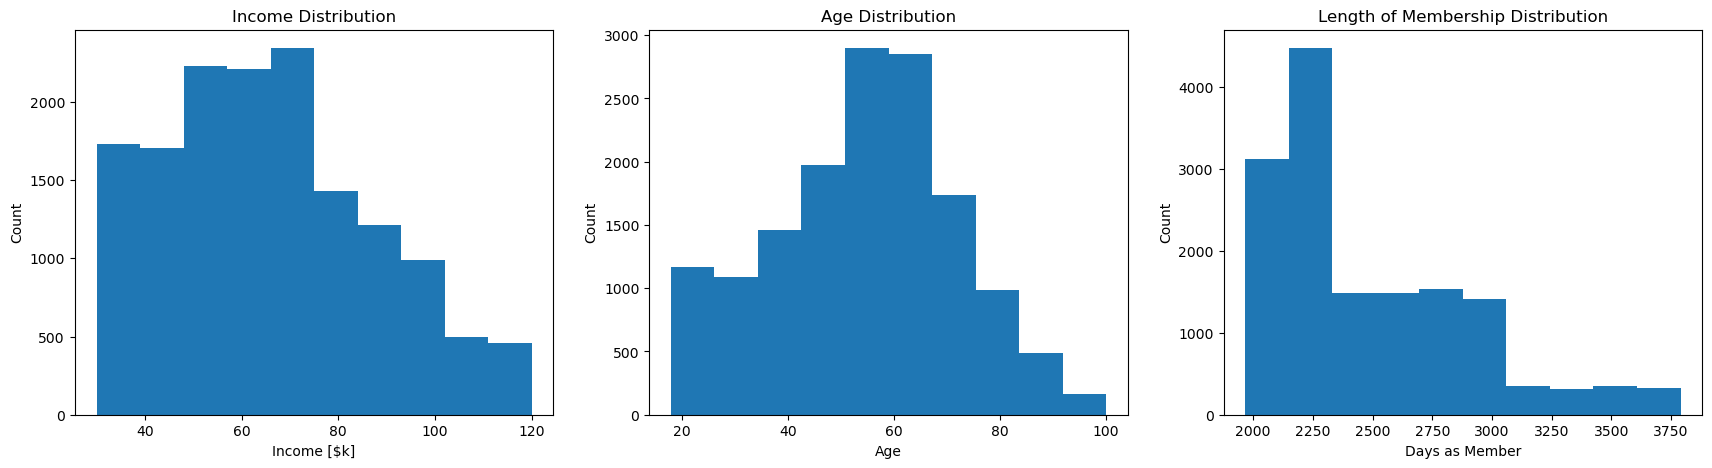

In [23]:
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

gender = ['orange','green','purple']

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(cleaned_profile['income'] * 1E-3)
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(cleaned_profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(cleaned_profile['member_days'])
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution')

Text(0.5, 1.0, 'Length of Membership Distribution - Non-Binary Customers')

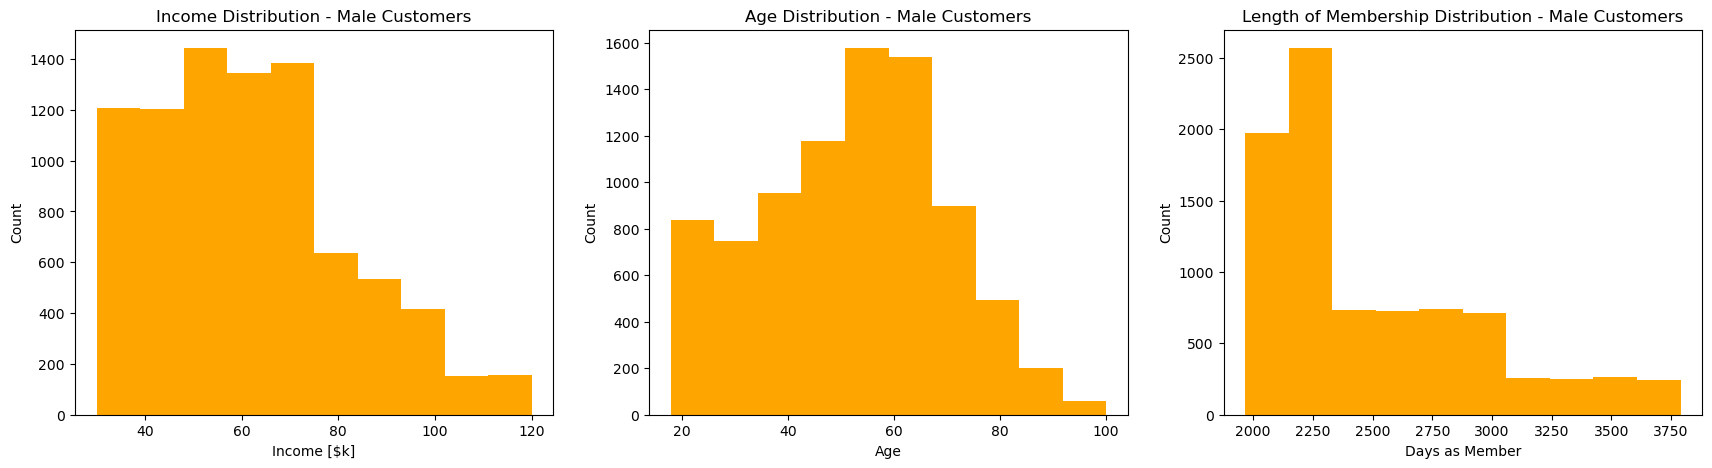

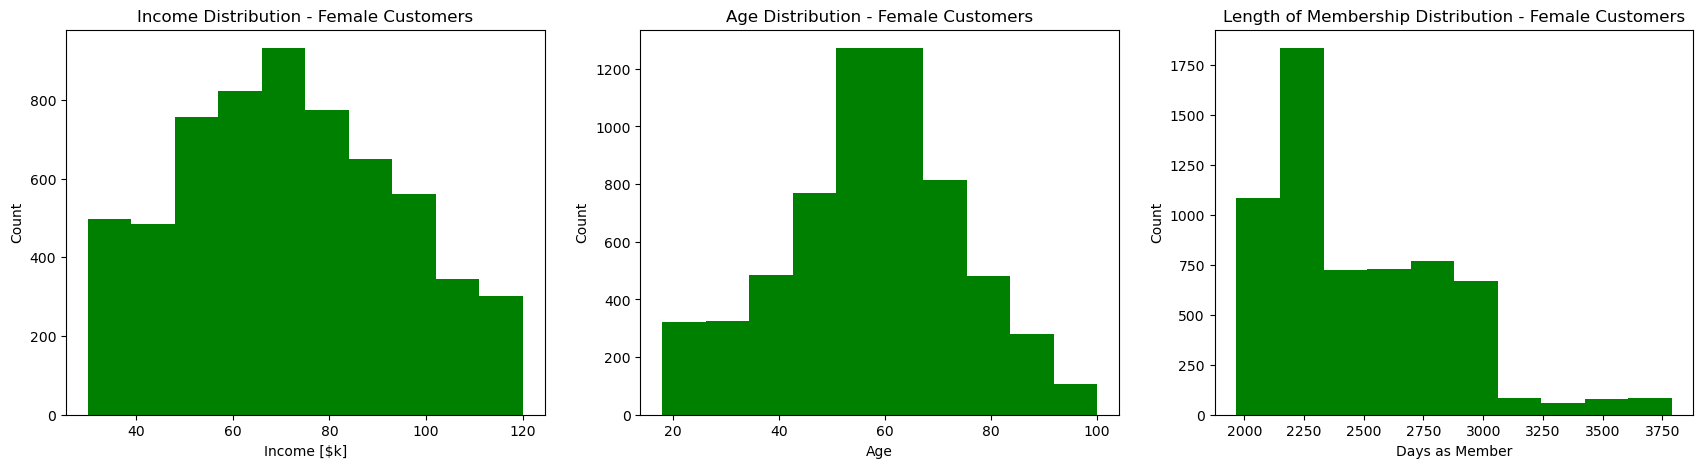

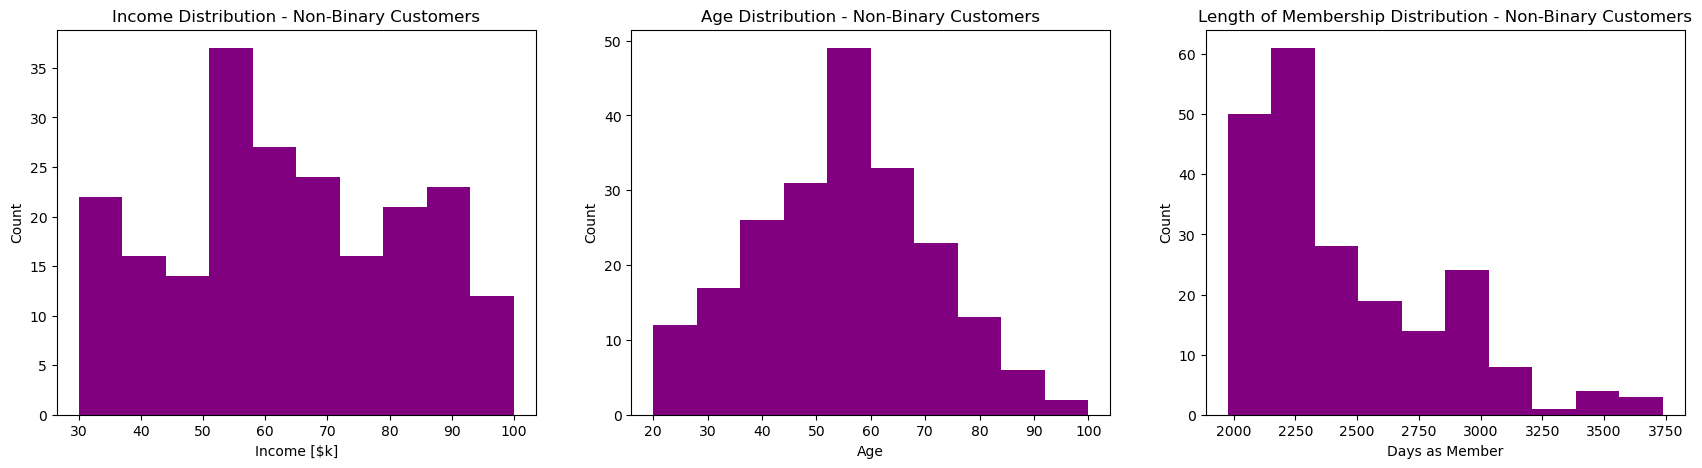

In [24]:
# View distributions by gender
male_customers = cleaned_profile[cleaned_profile['M'] == 1]
female_customers = cleaned_profile[cleaned_profile['F'] == 1]
nb_customers = cleaned_profile[cleaned_profile['O'] == 1]

male = ['orange']
female = ['green']
nb = ['purple']

# MALE
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(male_customers['income'] * 1E-3, color=male )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Male Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(male_customers['age'], color=male)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Male Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(male_customers['member_days'], color=male)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Male Customers')


# FEMALE
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(female_customers['income'] * 1E-3, color=female )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Female Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(female_customers['age'], color=female)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Female Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(female_customers['member_days'], color=female)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Female Customers')


# NB
# Chart out plots side by side
fig, ax = plt.subplots(figsize=(21, 5), nrows=1, ncols=3)

# Income Distribution Plot
plt.sca(ax[0])
plt.hist(nb_customers['income'] * 1E-3, color=nb )
plt.xlabel('Income [$k]')
plt.ylabel('Count')
plt.title('Income Distribution - Non-Binary Customers')

# Age Distribution Plot
plt.sca(ax[1])
plt.hist(nb_customers['age'], color=nb)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution - Non-Binary Customers')

# Length of Membership Distribution Plot
plt.sca(ax[2])
plt.hist(nb_customers['member_days'], color=nb)
plt.xlabel('Days as Member')
plt.ylabel('Count')
plt.title('Length of Membership Distribution - Non-Binary Customers')

### Cleaned_Portfolio

In [25]:
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,bogo,B1,1,1,1,0,1,0,0
1,10,10,120,bogo,B2,1,1,1,1,1,0,0
2,0,0,96,informational,I1,1,1,0,1,0,0,1
3,5,5,168,bogo,B3,1,1,0,1,1,0,0
4,5,20,240,discount,D1,1,0,0,1,0,1,0
5,3,7,168,discount,D2,1,1,1,1,0,1,0
6,2,10,240,discount,D3,1,1,1,1,0,1,0
7,0,0,72,informational,I2,1,1,1,0,0,0,1
8,5,5,120,bogo,B4,1,1,1,1,1,0,0
9,2,10,168,discount,D4,1,1,0,1,0,1,0


Questions of interest:
1. Success rate by offer type
2. Success rate by channel
3. Success rate by offer

I would need to:
1. Merge cleaned_portfolio with offers
2. Engineer offer success variable that accounts for received, viewed, completed events
3. Engineer success rate metrics

### Offers

In [63]:
offers

,customer_id,offer_id,event,hours,offer_received,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,B3,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,D1,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,D4,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,D3,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,B2,offer received,0,1,0,0
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,D2,offer completed,714,0,0,1
306506,b895c57e8cd047a8872ce02aa54759d6,D3,offer completed,714,0,0,1
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,D1,offer viewed,714,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,D3,offer completed,714,0,0,1


Questions of interest:
1. What is the distribution of offers received, viewed, and completed? 
2. What offers can be considered successful?

I would need to:
1. Determine which offers were received and viewed before completion (order by offer, then person)

Text(0.5, 1.0, 'Count of Offers Events by Offer ID')

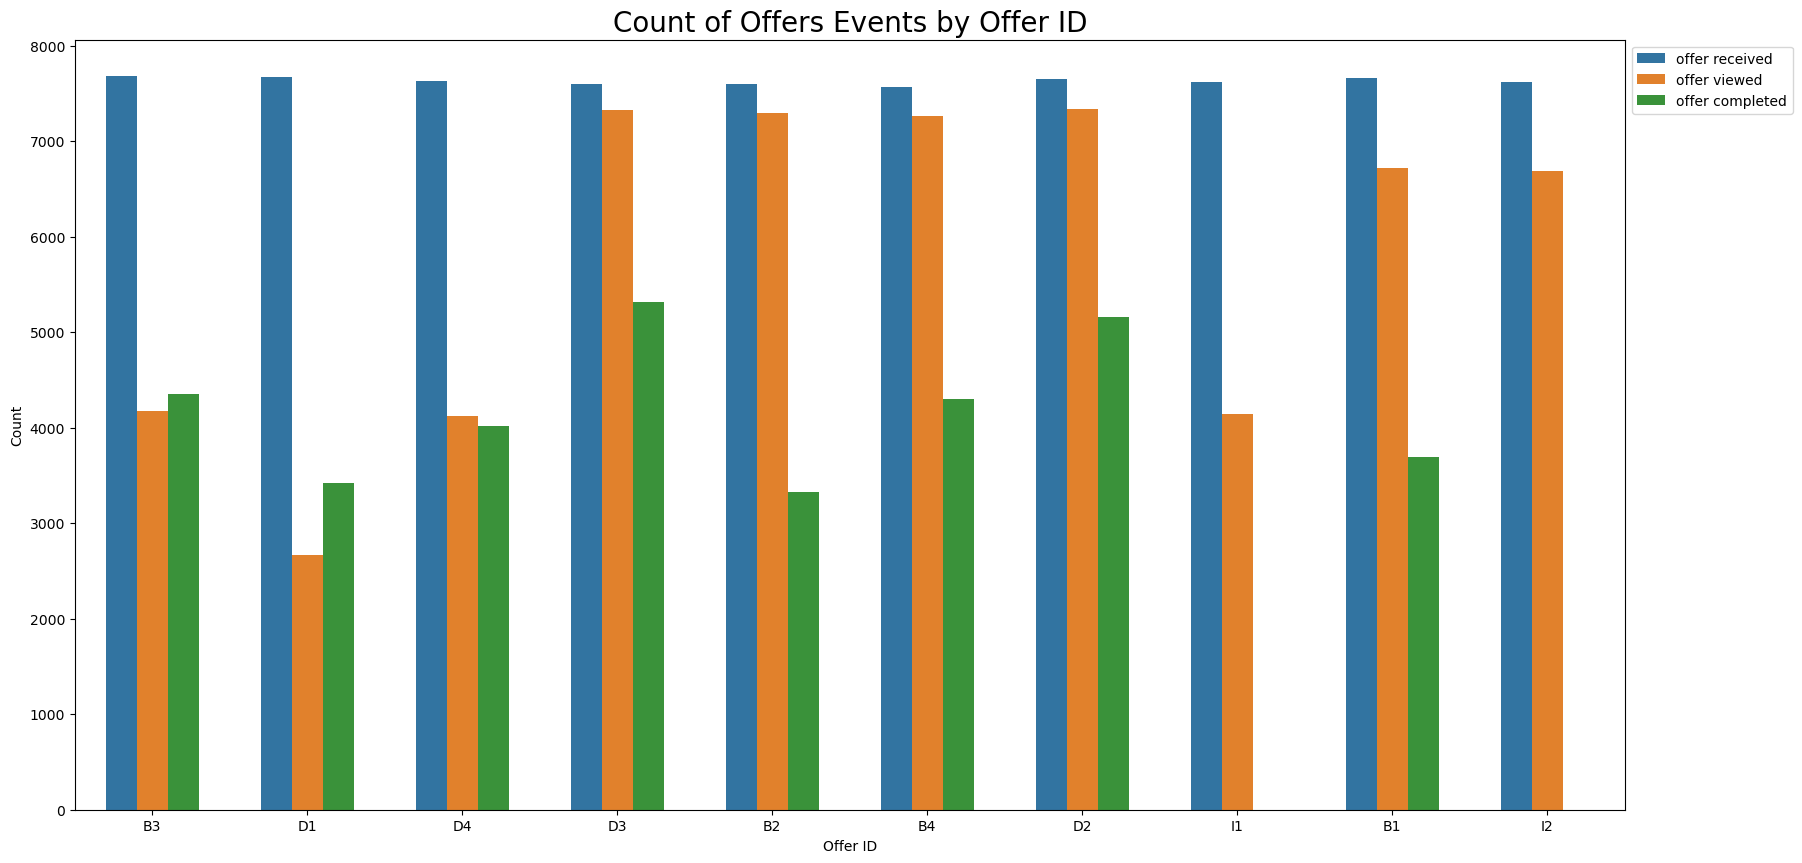

In [60]:
# Distribution of offer events by offer_id
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
ax = sns.countplot(data=offers, x='offer_id', hue='event', width=0.6)
ax.legend().set_title('')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Offer ID')
plt.ylabel('Count')
plt.title('Count of Offers Events by Offer ID', fontsize=20)

In [65]:
offers[(offers['offer_id']=='D1')]['offer_viewed'].sum()

2663

In [66]:
offers[(offers['offer_id']=='D1')]['offer_completed'].sum()

3420

We can see from this chart that each offer was sent/received approximately the same number of times. As we would expect, there is more variation in how many times an offer was viewed or completed. This chart also illustrates the point made in the project description: some offers may have been "completed" even though they were not viewed by the customer. Both B3 and D1 have a greater number of offers completed than offers viewed. So how can we determine when customers were successfully influenced by an offer to complete it?